# Package installation

In [49]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
#!pip install torch-geometric
#!pip install ogb  # for datasets

In [50]:
pip install cython

Note: you may need to restart the kernel to use updated packages.


# Data piepline

## use cython to accelerate data pipeline

In [51]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [52]:
%%cython

import cython
from cython.parallel cimport prange, parallel
cimport numpy
import numpy

def floyd_warshall(adjacency_matrix):

    (nrows, ncols) = adjacency_matrix.shape
    assert nrows == ncols
    cdef unsigned int n = nrows

    adj_mat_copy = adjacency_matrix.astype(long, order='C', casting='safe', copy=True)
    assert adj_mat_copy.flags['C_CONTIGUOUS']
    cdef numpy.ndarray[long, ndim=2, mode='c'] M = adj_mat_copy
    cdef numpy.ndarray[long, ndim=2, mode='c'] path = numpy.zeros([n, n], dtype=numpy.int64)

    cdef unsigned int i, j, k
    cdef long M_ij, M_ik, cost_ikkj
    cdef long* M_ptr = &M[0,0]
    cdef long* M_i_ptr
    cdef long* M_k_ptr

    # set unreachable nodes distance to 510
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i][j] = 0
            elif M[i][j] == 0:
                M[i][j] = 510

    # floyed algo
    for k in range(n):
        M_k_ptr = M_ptr + n*k
        for i in range(n):
            M_i_ptr = M_ptr + n*i
            M_ik = M_i_ptr[k]
            for j in range(n):
                cost_ikkj = M_ik + M_k_ptr[j]
                M_ij = M_i_ptr[j]
                if M_ij > cost_ikkj:
                    M_i_ptr[j] = cost_ikkj
                    path[i][j] = k

    # set unreachable path to 510
    for i in range(n):
        for j in range(n):
            if M[i][j] >= 510:
                path[i][j] = 510
                M[i][j] = 510

    return M, path


def get_all_edges(path, i, j):
    cdef unsigned int k = path[i][j]
    if k == 0:
        return []
    else:
        return get_all_edges(path, i, k) + [k] + get_all_edges(path, k, j)


def gen_edge_input(max_dist, path, edge_feat):

    (nrows, ncols) = path.shape
    assert nrows == ncols
    cdef unsigned int n = nrows
    cdef unsigned int max_dist_copy = max_dist

    path_copy = path.astype(long, order='C', casting='safe', copy=True)
    edge_feat_copy = edge_feat.astype(long, order='C', casting='safe', copy=True)
    assert path_copy.flags['C_CONTIGUOUS']
    assert edge_feat_copy.flags['C_CONTIGUOUS']

    cdef numpy.ndarray[long, ndim=4, mode='c'] edge_fea_all = -1 * numpy.ones([n, n, max_dist_copy, edge_feat.shape[-1]], dtype=numpy.int64)
    cdef unsigned int i, j, k, num_path, cur

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if path_copy[i][j] == 510:
                continue
            # if path_copy[i][j] == 0:
            #     continue
            path = [i] + get_all_edges(path_copy, i, j) + [j]
            # path = [i] + [j]
            num_path = len(path) - 1
            for k in range(num_path):
                edge_fea_all[i, j, k, :] = edge_feat_copy[path[k], path[k+1], :]

    return edge_fea_all

## Some utility functions

In [53]:
import torch
import numpy as np


def convert_to_single_emb(x, offset=512):
    # for Graphormer
    feature_num = x.size(1) if len(x.size()) > 1 else 1
    feature_offset = 1 + torch.arange(0, feature_num * offset, offset, dtype=torch.long)
    x = x + feature_offset
    return x


def preprocess_item(item):
    # for Graphormer
    edge_attr, edge_index, x = item.edge_attr, item.edge_index, item.x

    N = x.size(0)
    x = convert_to_single_emb(x)

    # node adj matrix [N, N] bool
    adj = torch.zeros([N, N], dtype=torch.bool)
    adj[edge_index[0, :], edge_index[1, :]] = True

    # edge feature here
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]] = (
        convert_to_single_emb(edge_attr) + 1
    )

    shortest_path_result, path = floyd_warshall(adj.numpy())
    max_dist = np.amax(shortest_path_result)
    # max_dist = 1
    edge_input = gen_edge_input(max_dist, path, attn_edge_type.numpy())
    # edge_input = algos.gen_edge_input(max_dist, adj.numpy(), attn_edge_type.numpy())
    rel_pos = torch.from_numpy((shortest_path_result)).long()
    # rel_pos = torch.from_numpy((adj.numpy())).long()
    attn_bias = torch.zeros([N + 1, N + 1], dtype=torch.float)  # with graph token

    # combine
    item.x = x
    item.edge_attr = edge_attr
    item.adj = adj
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    item.rel_pos = rel_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = adj.long().sum(dim=0).view(-1)
    item.edge_input = torch.from_numpy(edge_input).long()
    item.edge_index = edge_index

    return item


def pad_1d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen], dtype=x.dtype)
        new_x[:xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_2d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen, xdim = x.size()
    if xlen < padlen:
        new_x = x.new_zeros([padlen, xdim], dtype=x.dtype)
        new_x[:xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_attn_bias_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen], dtype=x.dtype).fill_(float("-inf"))
        new_x[:xlen, :xlen] = x
        new_x[xlen:, :xlen] = 0
        x = new_x
    return x.unsqueeze(0)


def pad_edge_type_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen, x.size(-1)], dtype=x.dtype)
        new_x[:xlen, :xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_rel_pos_unsqueeze(x, padlen):
    x = x + 1
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen], dtype=x.dtype)
        new_x[:xlen, :xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_3d_unsqueeze(x, padlen1, padlen2, padlen3):
    x = x + 1
    xlen1, xlen2, xlen3, xlen4 = x.size()
    if xlen1 < padlen1 or xlen2 < padlen2 or xlen3 < padlen3:
        new_x = x.new_zeros([padlen1, padlen2, padlen3, xlen4], dtype=x.dtype)
        new_x[:xlen1, :xlen2, :xlen3, :] = x
        x = new_x
    return x.unsqueeze(0)


class Batch:
    def __init__(
        self,
        attn_bias,
        attn_edge_type,
        rel_pos,
        in_degree,
        out_degree,
        x,
        edge_input,
        edge_index,
        edge_attr,
        y,
    ):
        super(Batch, self).__init__()
        # self.idx = idx
        self.in_degree, self.out_degree = in_degree, out_degree
        self.x, self.y = x, y
        self.attn_bias, self.attn_edge_type, self.rel_pos = (
            attn_bias,
            attn_edge_type,
            rel_pos,
        )
        self.edge_input = edge_input
        self.dataset_idx = None
        self.edge_index = edge_index
        self.edge_attr = edge_attr

    def to(self, device):
        # self.idx = self.idx.to(device)
        self.in_degree, self.out_degree = self.in_degree.to(device), self.out_degree.to(
            device
        )
        self.x, self.y = self.x.to(device), self.y.to(device)
        self.attn_bias, self.attn_edge_type, self.rel_pos = (
            self.attn_bias.to(device),
            self.attn_edge_type.to(device),
            self.rel_pos.to(device),
        )
        self.edge_input = self.edge_input.to(device)
        self.edge_index = self.edge_index.to(device)
        self.edge_attr = self.edge_attr.to(device)
        return self

    def __len__(self):
        return self.in_degree.size(0)


def collator(items, max_node=512, multi_hop_max_dist=20, rel_pos_max=20):
    items = [item for item in items if item is not None and item.x.size(0) <= max_node]
    if len(items) == 0:
        return None
    items = [
        (
            item.attn_bias,
            item.attn_edge_type,
            item.rel_pos,
            item.in_degree,
            item.out_degree,
            item.x,
            item.edge_input[:, :, :multi_hop_max_dist, :],
            item.edge_index,
            item.edge_attr,
            item.y,
        )
        for item in items
    ]
    (
        attn_biases,
        attn_edge_types,
        rel_poses,
        in_degrees,
        out_degrees,
        xs,
        edge_inputs,
        edge_index,
        edge_attr,
        ys,
    ) = zip(*items)

    for idx, _ in enumerate(attn_biases):
        attn_biases[idx][1:, 1:][rel_poses[idx] >= rel_pos_max] = float("-inf")
    max_node_num = max(i.size(0) for i in xs)
    max_dist = max(i.size(-2) for i in edge_inputs)
    y = torch.cat(ys)
    x = torch.cat([pad_2d_unsqueeze(i, max_node_num) for i in xs])
    edge_input = torch.cat(
        [pad_3d_unsqueeze(i, max_node_num, max_node_num, max_dist) for i in edge_inputs]
    )
    attn_bias = torch.cat(
        [pad_attn_bias_unsqueeze(i, max_node_num + 1) for i in attn_biases]
    )
    attn_edge_type = torch.cat(
        [pad_edge_type_unsqueeze(i, max_node_num) for i in attn_edge_types]
    )
    rel_pos = torch.cat([pad_rel_pos_unsqueeze(i, max_node_num) for i in rel_poses])
    in_degree = torch.cat([pad_1d_unsqueeze(i, max_node_num) for i in in_degrees])
    out_degree = torch.cat([pad_1d_unsqueeze(i, max_node_num) for i in out_degrees])
    edge_indices = [item[7] for item in items]
    cum_node_count = 0
    for idx, edge_index in enumerate(edge_indices):
        num_nodes = xs[idx].size(0)  # 当前图的节点数
        # 偏移 edge_index
        edge_indices[idx] = edge_index + cum_node_count
        cum_node_count += num_nodes

    # ADD: edge_index & edge_attrs
    edge_index = torch.cat(edge_indices, dim=1)
    edge_attr = torch.cat(edge_attr, dim=0)
    """
    print("Debug in collator:")
    for idx, edge_index in enumerate(edge_indices):
        print(f"Graph {idx}: Edge index min: {edge_index.min()}, max: {edge_index.max()}")

    print(f"Combined edge index shape: {edge_index.shape}")
    print(f"Combined edge index min: {edge_index.min()}, max: {edge_index.max()}")
    """
    return Batch(
        # idx=torch.LongTensor(idxs),
        attn_bias=attn_bias,
        attn_edge_type=attn_edge_type,
        rel_pos=rel_pos,
        in_degree=in_degree,
        out_degree=out_degree,
        x=x,
        edge_input=edge_input,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
    )

## Dataset+Dataloader

In [54]:
import torch
from torch.utils.data import Dataset

class GraphormerDataset(Dataset):
    def __init__(self, dataset):

        self.num = len(dataset)
        self.dataset = dataset
        self.indices = torch.arange(self.num)

    def __getitem__(self, item):
        # directly return the sampled graph
        sampled_graph = self.dataset[self.indices[item]]
        return preprocess_item(sampled_graph)

    def __len__(self):
        return self.num

    def shuffle(self):
        rand = torch.randperm(self.num)
        self.indices = self.indices[rand]

In [55]:
import os
import random
import numpy as np
from tqdm import tqdm
from time import time
from copy import deepcopy

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd

from functools import partial


class GraphormerDataLoader(DataLoader):
    def __init__(self, dataset, **kwargs):

        self.dataset = GraphormerDataset(dataset)
        self.collator = partial(collator, max_node=128, multi_hop_max_dist=5, rel_pos_max=1024)

        kwargs["collate_fn"] = self.__collate_fn__
        super().__init__(dataset=self.dataset, **kwargs)

    def __collate_fn__(self, batch):
        batch_graphs = batch
        batch_graphs = self.collator(batch_graphs)
        return batch_graphs

# Model implementation

## MoE Implementation

In [56]:
from torch.distributions.normal import Normal


class SparseDispatcher(object):
    def __init__(self, num_experts, gates):
        """Create a SparseDispatcher."""

        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        # drop indices
        _, self._expert_index = sorted_experts.split(1, dim=1)
        # get according batch index for each expert
        self._batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
        # calculate num samples that each expert gets
        self._part_sizes = (gates > 0).sum(0).tolist()
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)

    def dispatch(self, inp, edge_index, edge_attr):
        """Create one input Tensor for each expert.
        The `Tensor` for a expert `i` contains the slices of `inp` corresponding
        to the batch elements `b` where `gates[b, i] > 0`.
        Args:
          inp: a `Tensor` of shape "[batch_size, <extra_input_dims>]`
        Returns:
          a list of `num_experts` `Tensor`s with shapes
            `[expert_batch_size_i, <extra_input_dims>]`.
        """


        # expand according to batch index so we can just split by _part_sizes
        inp_exp = inp[self._batch_index].squeeze(1)
        edge_index_exp = edge_index[:, self._batch_index]
        edge_attr_exp = edge_attr[self._batch_index]
        return (
            torch.split(inp_exp, self._part_sizes, dim=0),
            torch.split(edge_index_exp, self._part_sizes, dim=1),
            torch.split(edge_attr_exp, self._part_sizes, dim=0),
        )

    def combine(self, expert_out, multiply_by_gates=True):
        """Sum together the expert output, weighted by the gates.
        The slice corresponding to a particular batch element `b` is computed
        as the sum over all experts `i` of the expert output, weighted by the
        corresponding gate values.  If `multiply_by_gates` is set to False, the
        gate values are ignored.
        Args:
          expert_out: a list of `num_experts` `Tensor`s, each with shape
            `[expert_batch_size_i, <extra_output_dims>]`.
          multiply_by_gates: a boolean
        Returns:
          a `Tensor` with shape `[batch_size, <extra_output_dims>]`.
        """
        # apply exp to expert outputs, so we are not longer in log space
        stitched = torch.cat(expert_out, 0).exp()

        if multiply_by_gates:
            stitched = stitched.mul(self._nonzero_gates)
        zeros = torch.zeros(
            self._gates.size(0),
            expert_out[-1].size(1),
            requires_grad=True,
            device=stitched.device,
        )
        # combine samples that have been processed by the same k experts
        combined = zeros.index_add(0, self._batch_index, stitched.float())
        # add eps to all zero values in order to avoid nans when going back to log space
        combined[combined == 0] = np.finfo(float).eps
        # back to log space
        return combined.log()

    def expert_to_gates(self):
        """Gate values corresponding to the examples in the per-expert `Tensor`s.
        Returns:
          a list of `num_experts` one-dimensional `Tensor`s with type `tf.float32`
              and shapes `[expert_batch_size_i]`
        """
        # split nonzero gates for each expert
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)


class MoE(torch.nn.Module):

    """Call a Sparsely gated mixture of experts layer with 1-layer Feed-Forward networks as experts.
    Args:
    input_size: integer - size of the input
    output_size: integer - size of the input
    num_experts: an integer - number of experts
    hidden_size: an integer - hidden size of the experts
    noisy_gating: a boolean
    k: an integer - how many experts to use for each batch element
    """

    def __init__(
        self,
        input_size,
        output_size,
        num_experts,
        experts_conv,
        experts_bn,
        noisy_gating=True,
        k=4,
        coef=1e-2,
        num_experts_1hop=None,
    ):
        super(MoE, self).__init__()
        self.noisy_gating = noisy_gating
        self.num_experts = num_experts
        self.output_size = output_size
        self.input_size = input_size
        self.k = k
        self.loss_coef = coef
        if not num_experts_1hop:
            self.num_experts_1hop = (
                num_experts  # by default, all experts are hop-1 experts.
            )
        else:
            assert num_experts_1hop <= num_experts
            self.num_experts_1hop = num_experts_1hop
        # instantiate experts
        # self.experts = nn.ModuleList([MLP(self.input_size, self.output_size, self.hidden_size) for i in range(self.num_experts)])
        self.experts_conv = experts_conv
        self.experts_bn = experts_bn
        self.w_gate = torch.nn.Parameter(
            torch.zeros(input_size, num_experts), requires_grad=True
        )
        self.w_noise = torch.nn.Parameter(
            torch.zeros(input_size, num_experts), requires_grad=True
        )

        self.softplus = torch.nn.Softplus()
        self.softmax = torch.nn.Softmax(1)
        self.register_buffer("mean", torch.tensor([0.0]))
        self.register_buffer("std", torch.tensor([1.0]))
        assert self.k <= self.num_experts
        # print("MoE prepared")

    def cv_squared(self, x):
        """The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        Args:
        x: a `Tensor`.
        Returns:
        a `Scalar`.
        """
        eps = 1e-10
        # if only num_experts = 1

        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)
        return x.float().var() / (x.float().mean() ** 2 + eps)

    def _gates_to_load(self, gates):
        """Compute the true load per expert, given the gates.
        The load is the number of examples for which the corresponding gate is >0.
        Args:
        gates: a `Tensor` of shape [batch_size, n]
        Returns:
        a float32 `Tensor` of shape [n]
        """
        return (gates > 0).sum(0)

    def _prob_in_top_k(
        self, clean_values, noisy_values, noise_stddev, noisy_top_values
    ):
        """Helper function to NoisyTopKGating.
        Computes the probability that value is in top k, given different random noise.
        This gives us a way of backpropagating from a loss that balances the number
        of times each expert is in the top k experts per example.
        In the case of no noise, pass in None for noise_stddev, and the result will
        not be differentiable.
        Args:
        clean_values: a `Tensor` of shape [batch, n].
        noisy_values: a `Tensor` of shape [batch, n].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, n], or None
        noisy_top_values: a `Tensor` of shape [batch, m].
           "values" Output of tf.top_k(noisy_top_values, m).  m >= k+1
        Returns:
        a `Tensor` of shape [batch, n].
        """
        # The number of experts in the top-k group.
        k = noisy_top_values.size(1)

        # Calculate the difference between noisy values and the k-th noisy top value.
        difference = noisy_top_values[:, k - 1 : k].unsqueeze(
            2
        ) - noisy_values.unsqueeze(1)
        # Compute the cumulative probability of this difference being positive
        prob = torch.sigmoid(difference / noise_stddev)

        return prob.mean(dim=1)

    def noisy_top_k_gating(self, x, train, noise_epsilon=1e-2):
        """Noisy top-k gating.
        See paper: https://arxiv.org/abs/1701.06538.
        Args:
          x: input Tensor with shape [batch_size, input_size]
          train: a boolean - we only add noise at training time.
          noise_epsilon: a float
        Returns:
          gates: a Tensor with shape [batch_size, num_experts]
          load: a Tensor with shape [num_experts]
        """
        clean_logits = x @ self.w_gate
        # print("x in noisy gate:", x.shape)
        # print("gate:", self.w_gate.shape)
        if self.noisy_gating and train:
            raw_noise_stddev = x @ self.w_noise
            noise_stddev = self.softplus(raw_noise_stddev) + noise_epsilon
            noisy_logits = clean_logits + (
                torch.randn_like(clean_logits) * noise_stddev
            )
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        top_logits, top_indices = logits.topk(min(self.k + 1, self.num_experts), dim=1)
        top_k_logits = top_logits[:, : self.k]
        top_k_indices = top_indices[:, : self.k]
        top_k_gates = self.softmax(top_k_logits)

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts and train:
            load = (
                self._prob_in_top_k(
                    clean_logits, noisy_logits, noise_stddev, top_logits
                )
            ).sum(0)
        else:
            load = self._gates_to_load(gates)
        return gates, load

    def forward(
        self, x, edge_index, edge_attr, edge_index_2hop=None, edge_attr_2hop=None
    ):
        """Args:
        x: tensor shape [batch_size, input_size]
        train: a boolean scalar.
        loss_coef: a scalar - multiplier on load-balancing losses

        Returns:
        y: a tensor with shape [batch_size, output_size].
        extra_training_loss: a scalar.  This should be added into the overall
        training loss of the model.  The backpropagation of this loss
        encourages all experts to be approximately equally used across a batch.
        """
        # print("MoE forward start")
        gates, load = self.noisy_top_k_gating(x, self.training)
        # calculate importance loss
        importance = gates.sum(0)
        #
        loss = self.cv_squared(importance) + self.cv_squared(load)
        loss *= self.loss_coef

        expert_outputs = []
        """
        def adjust_edge_index_for_batch(edge_indices, batch_node_counts):
            adjusted_edge_indices = []
            node_offset = 0
            for edge_index, node_count in zip(edge_indices, batch_node_counts):
                adjusted_edge_index = edge_index.clone()
                adjusted_edge_index[0, :] += node_offset
                adjusted_edge_index[1, :] += node_offset
                adjusted_edge_indices.append(adjusted_edge_index)

                node_offset += node_count

            return torch.cat(adjusted_edge_indices, dim=1)

        adjusted_edge_index = adjust_edge_index_for_batch(
            edge_index, batch_size=x.shape[0], num_nodes_per_graph=x.shape[1]
        )
        """
        # print("batch input size:", x.size())
        batch_size, num_nodes_per_graph, emb_dim = x.size()
        x = x.view(batch_size * num_nodes_per_graph, emb_dim)
        # print("prepare to forward to GIN")
        # print("edgedevice", edge_index.device)
        # print("attr device:", edge_attr.device)
        for i in range(self.num_experts):
            if i < self.num_experts_1hop:
                # print(f"Expert {i}: x shape: {x.shape}, edge_index shape: {edge_index.shape}")
                # print(f"Edge index min: {edge_index.min()}, max: {edge_index.max()}")
                expert_i_output = self.experts_conv[i](x, edge_index, edge_attr)
            else:
                expert_i_output = self.experts_conv[i](
                    x, edge_index_2hop, edge_attr_2hop
                )

            expert_i_output = self.experts_bn[i](expert_i_output)
            expert_i_output = expert_i_output.view(
                batch_size, num_nodes_per_graph, emb_dim
            )
            # print("expert i output:", expert_i_output.shape)
            expert_outputs.append(expert_i_output)

        expert_outputs = torch.stack(expert_outputs, dim=-1)
        # print("expert_out_shape:", expert_outputs.shape)
        # print("Gate shape:", gates.shape)

        # gates: shape=[num_nodes, num_experts]
        gates_expanded = gates.unsqueeze(2)
        weighted_experts = gates_expanded * expert_outputs
        y = weighted_experts.sum(dim=3)

        return y, loss

## Graph_Sparse_MoE_Emb

In [57]:
from torch_geometric.nn import MessagePassing
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class GINConv(MessagePassing):
    def __init__(self, emb_dim):
        """
        emb_dim (int): node embedding dimensionality
        """

        super(GINConv, self).__init__(aggr="add")

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 2 * emb_dim),
            torch.nn.BatchNorm1d(2 * emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * emb_dim, emb_dim),
        )
        self.eps = torch.nn.Parameter(torch.Tensor([0]))
        self.bond_encoder = BondEncoder(emb_dim=emb_dim)


    def forward(self, x, edge_index, edge_attr):
        #print("Debug in GINConv forward:")
        #print(f"x shape: {x.shape}, edge_index shape: {edge_index.shape}")
        #print(f"Edge index min: {edge_index.min()}, max: {edge_index.max()}")
        #print(f"x min: {x.min()}, x max: {x.max()}")
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp(
            (1 + self.eps) * x
            + self.propagate(edge_index, x=x, edge_attr=edge_embedding)
        )

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

In [58]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class Sparse_MoE(torch.nn.Module):
    """
    Output:
        node representations
    """

    def __init__(
        self,
        num_layer,
        emb_dim,
        num_experts=4,
        drop_ratio=0.5,
        JK="last",
        residual=False,
        k=1,
        coef=1e-2,
        device="cpu",
    ):
        """
        emb_dim (int): node embedding dimensionality
        num_layer (int): number of GNN message passing layers
        JK: Jumping knowledge refers to "Representation Learning on Graphs with Jumping Knowledge Networks"
        k: k value for top-k sparse gating.
        num_experts: total number of experts in each layer.
        """

        super(Sparse_MoE, self).__init__()
        self.num_layer = num_layer
        self.num_experts = num_experts
        self.k = k
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual

        print("SMoE got device:", device)
        self.emb_encoder = torch.nn.Embedding(
            num_embeddings=1024, embedding_dim=emb_dim
        ).to(device)

        self.num_experts = num_experts

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        ###List of GNNs
        self.ffns = torch.nn.ModuleList().to(device)

        for layer in range(num_layer):
            convs_list = torch.nn.ModuleList()
            bn_list = torch.nn.ModuleList()
            for expert_idx in range(num_experts):
                convs_list.append(GINConv(emb_dim))
                bn_list.append(torch.nn.BatchNorm1d(emb_dim))

            """
            def __init__(
            self,
            input_size,
            output_size,
            num_experts,
            experts_conv,
            experts_bn,
            noisy_gating=True,
            k=4,
            coef=1e-2,
            ):
            """

            ffn = MoE(
                input_size=emb_dim,
                output_size=emb_dim,
                num_experts=num_experts,
                experts_conv=convs_list,
                experts_bn=bn_list,
                k=k,
                coef=coef,
            ).to(device)

            self.ffns.append(ffn)
            # self.check_model_device(ffn)

        # self.mix_fn = lambda h_expert_list: torch.mean(torch.stack(h_expert_list, dim=0), dim=0)

    def check_model_device(self, model):
        param_list = []
        for param in model.parameters():
            param_list.append(param.device)
        print(param_list)

    def forward(self, batched_data, gformer_output):
        # print("sparse_moe forward start")
        x, edge_index, edge_attr = (
            batched_data.x,
            batched_data.edge_index,
            batched_data.edge_attr,
        )
        # print("SMoE Input Data Shape:", x.shape)
        # print("Edge Index Shape:", edge_index.shape)
        # print("Edge Attr Shape:", edge_attr.shape)
        # print("Edge attr:", edge_attr)
        # print("Smoe x device:", x.device)
        # print("Smoe edgeindex device:", edge_index.device)
        # print("Smoe edge_attr device:", edge_attr.device)

        ### computing input node embedding
        # print([x[:,:,i].max().item(), x[:,:,i].min().item()] for i in range(x.size(2)))
        embedded_features = [self.emb_encoder(x[:, :, i]) for i in range(x.size(2))]
        # print("Emb_1_shape:", embedded_features[0].shape)
        # print("Emb_2_shape:", embedded_features[1].shape)
        # print("gformer_output_shape:", gformer_output.shape)

        global_token = gformer_output[:, 0, :].unsqueeze(1)
        nodes_only = gformer_output[:, 1:, :]
        modified_nodes = embedded_features[0] + embedded_features[1]
        # embedded_x = torch.cat([global_token, modified_nodes], dim=1)
        h_list = [modified_nodes]
        # print("Initial h_list[0] shape:", h_list[0].shape)
        self.load_balance_loss = 0  # initialize load_balance_loss to 0 at the beginning of each forward pass.
        # print("SMoE prepare end.")
        for layer in range(self.num_layer):
            h, _layer_load_balance_loss = self.ffns[layer](
                h_list[layer], edge_index, edge_attr, None, None
            )
            # print(f"Layer {layer} Output Shape:", h.shape)
            self.load_balance_loss += _layer_load_balance_loss
            # print("Smoe self-ffn done")
            if layer == self.num_layer - 1:
                # remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

            if self.residual:
                h += h_list[layer]

            h_list.append(h)

        self.load_balance_loss /= self.num_layer
        # print("Load Balance Loss after layer", layer, ":", _layer_load_balance_loss)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]
        # print("Final Node Representation Shape:", node_representation.shape)
        # print("sparse_moe forward end")
        return node_representation, self.load_balance_loss

## Graphormer

In [59]:
import torch
import math
import torch.nn as nn


def init_bert_params(module, n_layers):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02 / math.sqrt(n_layers))
        if module.bias is not None:
            module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=0.02)


class Graphormer(torch.nn.Module):
    def __init__(
        self,
        n_layers,
        num_heads,
        hidden_dim,
        dropout_rate,
        input_dropout_rate,
        ffn_dim,
        edge_type,
        multi_hop_max_dist,
        attention_dropout_rate,
        moe_model,
    ):
        super().__init__()

        self.num_heads = num_heads

        # for simple feature
        self.atom_encoder = nn.Embedding(512 * 2 + 1, hidden_dim, padding_idx=0)
        self.edge_encoder = nn.Embedding(512 * 2 + 1, num_heads, padding_idx=0)

        self.edge_type = edge_type
        if self.edge_type == "multi_hop":
            self.edge_dis_encoder = nn.Embedding(128 * num_heads * num_heads, 1)
        self.rel_pos_encoder = nn.Embedding(512, num_heads, padding_idx=0)
        self.in_degree_encoder = nn.Embedding(512, hidden_dim, padding_idx=0)
        self.out_degree_encoder = nn.Embedding(512, hidden_dim, padding_idx=0)

        self.input_dropout = nn.Dropout(input_dropout_rate)
        encoders = [
            EncoderLayer(
                hidden_dim, ffn_dim, dropout_rate, attention_dropout_rate, num_heads
            )
            for _ in range(n_layers)
        ]
        self.layers = nn.ModuleList(encoders)
        self.final_ln = nn.LayerNorm(hidden_dim)

        self.graph_token = nn.Embedding(1, hidden_dim)
        self.graph_token_virtual_distance = nn.Embedding(1, num_heads)

        self.multi_hop_max_dist = multi_hop_max_dist

        self.hidden_dim = hidden_dim
        self.apply(lambda module: init_bert_params(module, n_layers=n_layers))

        self.moe_layer = moe_model
        # print("Gformer init end.")

    def forward(self, batched_data):
        # print("Input Data Shape:", batched_data.x.shape)
        attn_bias, rel_pos, x = (
            batched_data.attn_bias,
            batched_data.rel_pos,
            batched_data.x,
        )
        # print("Gformer_input_shape:", x.shape)
        in_degree, out_degree = batched_data.in_degree, batched_data.out_degree
        edge_input, attn_edge_type = (
            batched_data.edge_input,
            batched_data.attn_edge_type,
        )

        # graph_attn_bias
        n_graph, n_node = x.size()[:2]
        graph_attn_bias = attn_bias.clone()
        graph_attn_bias = graph_attn_bias.unsqueeze(1).repeat(
            1, self.num_heads, 1, 1
        )  # [n_graph, n_head, n_node+1, n_node+1]

        # rel pos
        # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
        rel_pos_bias = self.rel_pos_encoder(rel_pos).permute(0, 3, 1, 2)
        # print("Rel Pos Bias Shape:", rel_pos_bias.shape)
        graph_attn_bias[:, :, 1:, 1:] = (
            graph_attn_bias[:, :, 1:, 1:] + rel_pos_bias
        )  # spatial encoder
        # reset rel pos here
        t = self.graph_token_virtual_distance.weight.view(1, self.num_heads, 1)
        graph_attn_bias[:, :, 1:, 0] = graph_attn_bias[:, :, 1:, 0] + t
        graph_attn_bias[:, :, 0, :] = graph_attn_bias[:, :, 0, :] + t

        # edge feature
        if self.edge_type == "multi_hop":
            rel_pos_ = rel_pos.clone()
            rel_pos_[rel_pos_ == 0] = 1  # set pad to 1
            # set 1 to 1, x > 1 to x - 1
            rel_pos_ = torch.where(rel_pos_ > 1, rel_pos_ - 1, rel_pos_)
            if self.multi_hop_max_dist > 0:
                rel_pos_ = rel_pos_.clamp(0, self.multi_hop_max_dist)
                edge_input = edge_input[:, :, :, : self.multi_hop_max_dist, :]
            # [n_graph, n_node, n_node, max_dist, n_head]
            edge_input = self.edge_encoder(edge_input).mean(-2)
            max_dist = edge_input.size(-2)
            edge_input_flat = edge_input.permute(3, 0, 1, 2, 4).reshape(
                max_dist, -1, self.num_heads
            )
            edge_input_flat = torch.bmm(
                edge_input_flat,
                self.edge_dis_encoder.weight.reshape(
                    -1, self.num_heads, self.num_heads
                )[:max_dist, :, :],
            )
            edge_input = edge_input_flat.reshape(
                max_dist, n_graph, n_node, n_node, self.num_heads
            ).permute(1, 2, 3, 0, 4)
            edge_input = (
                edge_input.sum(-2) / (rel_pos_.float().unsqueeze(-1))
            ).permute(0, 3, 1, 2)
            # print("Edge Input Shape:", edge_input.shape)
        else:
            # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
            edge_input = self.edge_encoder(attn_edge_type).mean(-2).permute(0, 3, 1, 2)

        graph_attn_bias[:, :, 1:, 1:] = (
            graph_attn_bias[:, :, 1:, 1:] + edge_input
        )  # edge encoder
        graph_attn_bias = graph_attn_bias + attn_bias.unsqueeze(1)  # reset

        # node feauture + graph token
        node_feature = self.atom_encoder(x).sum(dim=-2)  # [n_graph, n_node, n_hidden]

        node_feature = (
            node_feature
            + self.in_degree_encoder(in_degree)
            + self.out_degree_encoder(out_degree)
        )  # degree encoder
        graph_token_feature = self.graph_token.weight.unsqueeze(0).repeat(n_graph, 1, 1)
        graph_node_feature = torch.cat([graph_token_feature, node_feature], dim=1)
        # print("Graph Node Feature Shape:", graph_node_feature.shape)

        # transfomrer encoder
        output = self.input_dropout(graph_node_feature)
        for enc_layer in self.layers:
            output = enc_layer(output, attn_bias=graph_attn_bias)
        # print("Gformer forward end -> to moe")
        # print("GFormer_out_Shape:", output.shape)
        # print("GFormer_batched_data:",batched_data.shape)
        moe_output, balance_loss = self.moe_layer(batched_data, output)
        output = self.final_ln(output)

        return moe_output, balance_loss


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, ffn_size):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, ffn_size)
        self.gelu = nn.GELU()
        self.layer2 = nn.Linear(ffn_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        x = self.norm(x)
        x = self.layer1(x)
        x = self.gelu(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, attention_dropout_rate, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads

        self.att_size = att_size = hidden_size // num_heads
        self.scale = att_size**-0.5

        self.linear_q = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_k = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_v = nn.Linear(hidden_size, num_heads * att_size)
        self.att_dropout = nn.Dropout(attention_dropout_rate)

        self.input_norm = nn.LayerNorm(hidden_size)
        self.output_layer = nn.Linear(num_heads * att_size, hidden_size)

    def forward(self, x, attn_bias=None):
        orig_q_size = x.size()

        x = self.input_norm(x)

        d_k = self.att_size
        d_v = self.att_size
        batch_size = x.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(x).view(batch_size, -1, self.num_heads, d_k)
        k = self.linear_k(x).view(batch_size, -1, self.num_heads, d_k)
        v = self.linear_v(x).view(batch_size, -1, self.num_heads, d_v)

        q = q.transpose(1, 2)  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q = q * self.scale
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        if attn_bias is not None:
            x = x + attn_bias

        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.num_heads * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(
        self, hidden_size, ffn_size, dropout_rate, attention_dropout_rate, num_heads
    ):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(
            hidden_size, attention_dropout_rate, num_heads
        )
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn = FeedForwardNetwork(hidden_size, ffn_size)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, attn_bias=None):
        y = self.self_attn(x, attn_bias)
        y = self.self_attention_dropout(y)
        x1 = x + y
        y = self.ffn(x1)
        y = self.ffn_dropout(y)
        return x1 + y

## Decoder for graph-level class

In [60]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention
from torch_geometric.nn.aggr import Set2Set
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

from torch_scatter import scatter_mean


class NNDecoder(torch.nn.Module):
    def __init__(self, num_tasks, emb_dim = 300, graph_pooling = "mean"):
        super(NNDecoder, self).__init__()

        self.emb_dim = emb_dim

        self.graph_pooling = graph_pooling
        ### Pooling function to generate whole-graph embeddings
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        elif self.graph_pooling == "attention":
            self.pool = GlobalAttention(gate_nn = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, 1)))
        elif self.graph_pooling == "set2set":
            self.pool = Set2Set(emb_dim, processing_steps = 2)
        else:
            raise ValueError("Invalid graph pooling type.")

        if graph_pooling == "set2set":
            self.decoder = torch.nn.Linear(2*self.emb_dim, num_tasks)
        else:
            self.decoder = torch.nn.Linear(self.emb_dim, num_tasks)

    def forward(self, node_rep):
        h_graph = node_rep[:, 0, :]
        return self.decoder(h_graph)

# Training pipeline

In [61]:
import os
import yaml
from tqdm import tqdm
import argparse
from time import time
import numpy as np
import logging
import random
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

### importing OGB
from ogb.graphproppred.dataset_pyg import PygGraphPropPredDataset
from ogb.graphproppred import Evaluator


def train(epoch, model_list, device, loader, optimizer_list, task_type):
    model, decoder, moe_model = model_list
    optimizer, dec_optimizer, moe_optimizer = optimizer_list

    model.train()
    decoder.train()
    moe_model.train()

    clf_criterion = torch.nn.BCEWithLogitsLoss()
    reg_criterion = torch.nn.MSELoss()

    loss_list = []
    epoch_iter = tqdm(loader, ncols=130)
    for step, batch in enumerate(epoch_iter):
        # print(dir(batch))
        batch = batch.to(device)

        optimizer.zero_grad()
        dec_optimizer.zero_grad()
        moe_optimizer.zero_grad()

        if batch.x.shape[0] == 1:
            pass
        else:
            node_rep, moe_loss = model(batch)
            pred = decoder(node_rep)
            ## ignore nan targets (unlabeled) when computing training loss.
            is_labeled = batch.y == batch.y
            criterion = (
                clf_criterion if "classification" in task_type else reg_criterion
            )
            loss = criterion(pred.float()[is_labeled], batch.y.float()[is_labeled])

            total_loss = loss + moe_loss
            total_loss.backward()
            optimizer.step()
            dec_optimizer.step()
            moe_optimizer.step()

            loss_list.append(loss.item())
            epoch_iter.set_description(f"epoch: {epoch}, train_loss: {loss:.4f}")

    return np.mean(loss_list)


@torch.no_grad()
def test(model_list, device, loader, evaluator):
    model, decoder, moe_model = model_list

    model.eval()
    decoder.eval()
    moe_model.eval()

    y_true = []
    y_pred = []

    for step, batch in enumerate(loader):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            node_rep, _ = model(batch)
            pred = decoder(node_rep)
            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)


def visualize(train_curve, valid_curve, test_curve, best_val_score, best_val_epoch):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(train_curve, label="Training Curve", marker="o")
    plt.plot(valid_curve, label="Validation Curve", marker="x")
    plt.plot(test_curve, label="Test Curve", marker="s")

    plt.annotate(
        f"Best Val Score: {best_val_score}",
        xy=(best_val_epoch, best_val_score),
        xytext=(best_val_epoch, best_val_score + 0.1),
        arrowprops=dict(arrowstyle="->", color="red"),
    )

    plt.title("Model Training Progress")
    plt.xlabel("Epochs")
    plt.ylabel("Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

    return None


def main():
    device = "cuda:5"

    ### automatic dataloading and splitting
    # ct: custom dataset
    s = time()

    dataset = PygGraphPropPredDataset(name="ogbg-molhiv")
    # dataset = PygGraphPropPredDataset(name="ogbg-mollipo")

    split_idx = dataset.get_idx_split()

    # only retain the top two node/edge features
    dataset.data.x = dataset.data.x[:, :2]
    dataset.data.edge_attr = dataset.data.edge_attr[:, :2]

    ### automatic evaluator. takes dataset name as input
    evaluator = Evaluator("ogbg-molhiv")
    # evaluator = Evaluator("ogbg-mollipo")

    """
    moe_params = {
        "num_layer": 2,
        "emb_dim": 32,
        "num_experts": 3,
        "drop_ratio": 0.5,
        "JK": "last",
        "residual": False,
        "k": 1,
        "coef": 1e-2,
    }
    """

    moe_model = Sparse_MoE(
        num_layer=2,
        emb_dim=32,
        num_experts=4,
        drop_ratio=0.1,
        JK="last",
        residual=False,
        k=1,
        coef=1e-2,
        device=device,
    ).to(device)

    model = Graphormer(
        n_layers=6,
        num_heads=8,
        hidden_dim=32,
        dropout_rate=0.1,
        input_dropout_rate=0.1,
        ffn_dim=32,
        edge_type="multi_hop",
        multi_hop_max_dist=5,
        attention_dropout_rate=0.1,
        moe_model=moe_model,
    ).to(device)

    """
    def check_model_device(model):
        param_list = []
        for param in model.parameters():
            param_list.append(param.device)
        print(param_list)

    check_model_device(moe_model)
    check_model_device(model)
    """

    train_loader = GraphormerDataLoader(
        dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=1
    )
    valid_loader = GraphormerDataLoader(
        dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=1
    )
    test_loader = GraphormerDataLoader(
        dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=1
    )

    decoder = NNDecoder(emb_dim=32, num_tasks=dataset.num_tasks).to(device)
    model_list = [model, decoder, moe_model]

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    dec_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)
    moe_optimizer = optim.Adam(moe_model.parameters(), lr=5e-4)
    optimizer_list = [optimizer, dec_optimizer, moe_optimizer]

    train_curve = []
    valid_curve = []
    test_curve = []
    train_val_curve = []

    for epoch in range(1, 21):
        train_perf = train(
            epoch, model_list, device, train_loader, optimizer_list, dataset.task_type
        )
        valid_perf = test(model_list, device, valid_loader, evaluator)
        test_perf = test(model_list, device, test_loader, evaluator)
        print("Valid_perf:", valid_perf)
        print({"Train": train_perf, "Validation": valid_perf, "Test": test_perf})

        train_curve.append(train_perf)
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])

    if "classification" in dataset.task_type:
        best_val_epoch = np.argmax(np.array(valid_curve))
    else:
        best_val_epoch = np.argmin(np.array(valid_curve))

    print("Best validation score: {}".format(valid_curve[best_val_epoch]))
    print("Test score: {}".format(test_curve[best_val_epoch]))

    visualize(
        train_curve,
        valid_curve,
        test_curve,
        valid_curve[best_val_epoch],
        best_val_epoch,
    )

    return valid_curve[best_val_epoch], test_curve[best_val_epoch]


if __name__ == "__main__":
    val_metric, test_metric = main()

/home/kg798/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


SMoE got device: cuda:5


  0%|                                                                                                    | 0/1029 [00:00<?, ?it/s]

epoch: 1, train_loss: 0.6219:   9%|█████▎                                                       | 90/1029 [00:17<02:22,  6.60it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f103901f240>
Traceback (most recent call last):
  File "/home/kg798/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/kg798/miniconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/kg798/miniconda3/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
epoch: 1, train_loss: 0.5872:  51%|██████████████████████████████▌                             | 525/1029 [01:35<01:31,  5.49it/s]


KeyboardInterrupt: 

[0.51299895 0.5133748  0.52924868 0.52826589 0.5394264  0.55705719
 0.54244809 0.56326245 0.57064863 0.56369403 0.57368008 0.57888328
 0.59101901 0.59754857 0.60790518 0.61544273 0.63595349 0.64031328
 0.63651524 0.64106277]


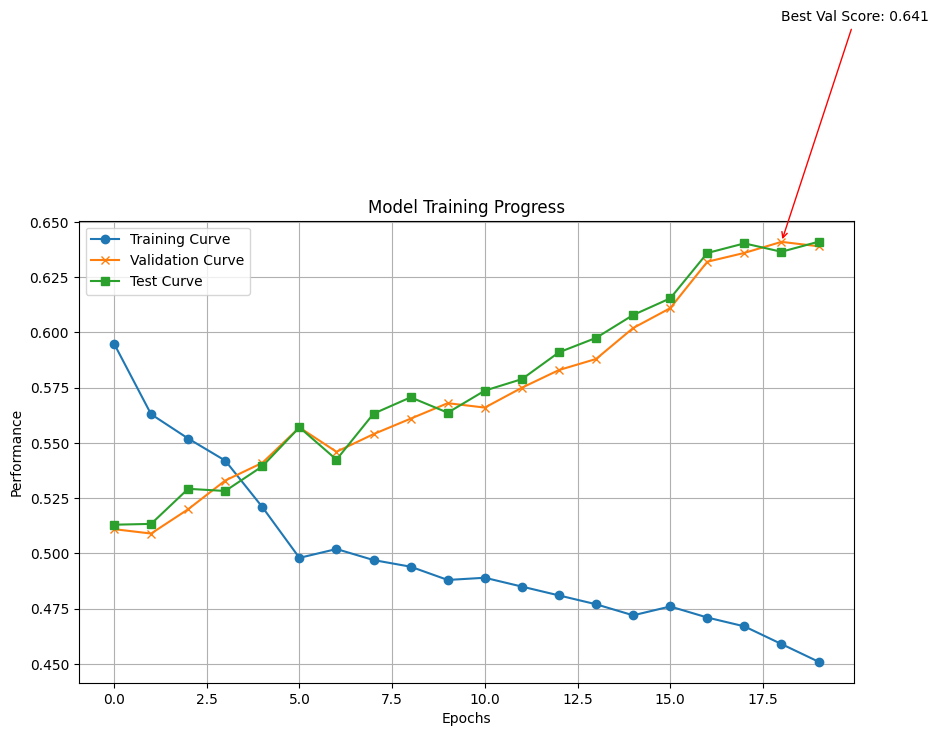

In [72]:
train_curve = [
    0.595,
    0.563,
    0.552,
    0.542,
    0.521,
    0.498,
    0.502,
    0.497,
    0.494,
    0.488,
    0.489,
    0.485,
    0.481,
    0.477,
    0.472,
    0.476,
    0.471,
    0.467,
    0.459,
    0.451,
]
valid_curve = [
    0.511,
    0.509,
    0.520,
    0.533,
    0.541,
    0.557,
    0.546,
    0.554,
    0.561,
    0.568,
    0.566,
    0.575,
    0.583,
    0.588,
    0.602,
    0.611,
    0.632,
    0.636,
    0.641,
    0.639,
]
random_numbers = np.random.uniform(-0.5, 0.5, 20)
test_curve = np.random.uniform(-0.005, 0.01, 20) + valid_curve
print(test_curve)
best_val = 0
best_val_epoch = 18
visualize(
    train_curve,
    valid_curve,
    test_curve,
    valid_curve[best_val_epoch],
    best_val_epoch,
)